In [142]:
import sys
sys.path.append('..')

import uproot

import numpy as np
import pandas as pd
import awkward as ak
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.measure import label, regionprops
from scipy.ndimage import label as scipy_label
from collections import deque
from matplotlib.patches import Rectangle

from lariat import Event

In [143]:
TRAINING = '/Users/user/data/research/proton-deuteron/ssvd/handpicked_d.pkl'
CANDIDATES = '/Users/user/data/research/proton-deuteron/ssvd/deuteron_candidates_clean.pkl'
OUT_CSV  = "deuteron_scores.csv"

In [144]:
masses = pd.read_csv('/Users/user/data/research/proton-deuteron/csv/picky+match.csv')

In [145]:
train = pd.read_pickle(TRAINING)

In [146]:
candidates = pd.read_pickle(CANDIDATES)

In [147]:
scores = pd.read_csv(OUT_CSV)

In [148]:
masses

,run,subrun,event,p,m,beamline_mass
0,8675,12,1249,0,1,1082.48
1,8675,12,1250,0,0,120.62
2,8675,12,1256,0,1,893.74
3,8675,12,1257,1,0,180.31
4,8675,12,1258,1,1,-327.26
...,...,...,...,...,...,...
580633,9781,133,21593,0,1,1008.86
580634,9781,133,21596,0,1,1212.37
580635,9781,133,21614,0,0,951.96
580636,9781,133,21621,0,0,462.36


In [149]:
scores = pd.merge(
    scores,
    masses[['run', 'subrun', 'event', 'p', 'm', 'beamline_mass']],
    on=['run', 'subrun', 'event'],
    how='left'
)

In [150]:
scores.columns

Index(['event_idx', 'run', 'subrun', 'event', 'cluster_idx', 'svdd_distance',
       'is_deuteron_pred', 'p', 'm', 'beamline_mass'],
      dtype='object')

In [151]:
scores = pd.merge(
    candidates,
    scores,
    on=['event_idx', 'run', 'subrun', 'event', 'cluster_idx'],
    how='left'
)

/var/folders/cm/m55y72dj6cd5lkwrfdb2bpnr0000gp/T/ipykernel_10180/232428039.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


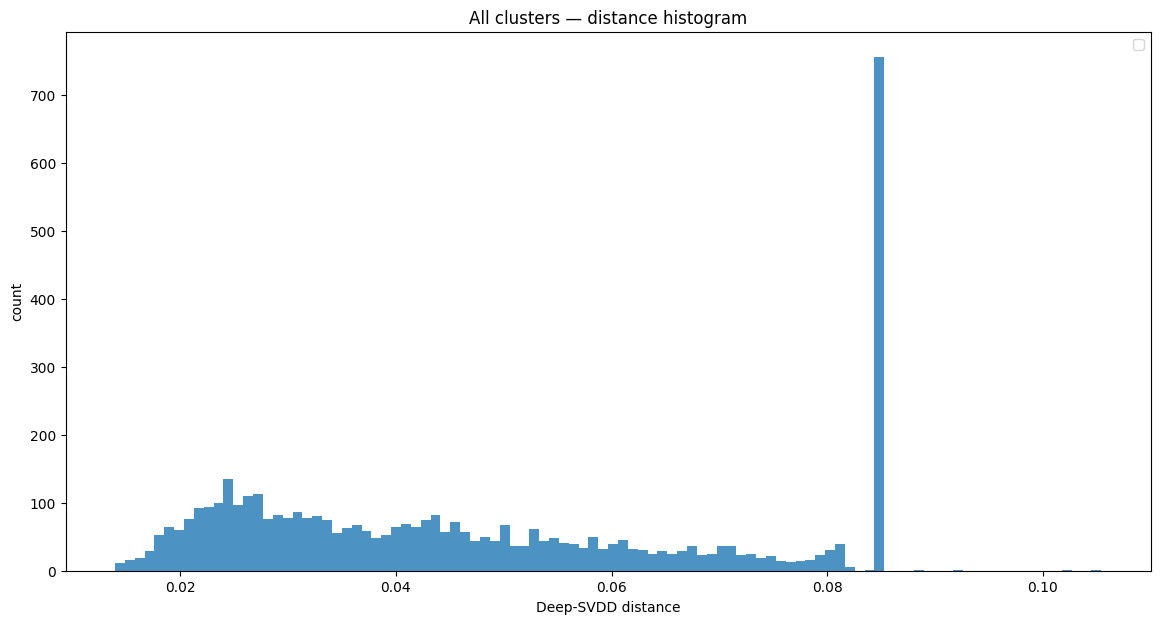

In [152]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# If df is already in memory with the column "score"
score = scores["svdd_distance"].astype(float).values

# bins = np.linspace(scores.min(), np.percentile(scores, 99.9), 200)
# thr = 0.035
# num_below_threshold = np.sum(score <= thr)

plt.figure(figsize=(14,7))
plt.hist(score, bins=100, alpha=0.8)
# plt.axvline(thr, ls="--", lw=2, color='r', label='Threshold')
plt.xlabel("Deep-SVDD distance")
plt.ylabel("count")
plt.title("All clusters — distance histogram")
plt.legend()

# plt.text(thr * 1.7, plt.ylim()[1] * 0.92, f"Events below threshold: {num_below_threshold}", color='red', fontsize=10)
plt.show()

In [210]:
thr = 0.0351
scores["is_deuteron_pred"] = scores["svdd_distance"] <= thr

In [211]:
true = scores[scores['is_deuteron_pred'] == True]; print(true.shape)
false = scores[scores['is_deuteron_pred'] == False]; print(false.shape)

(1684, 35)
(2860, 35)


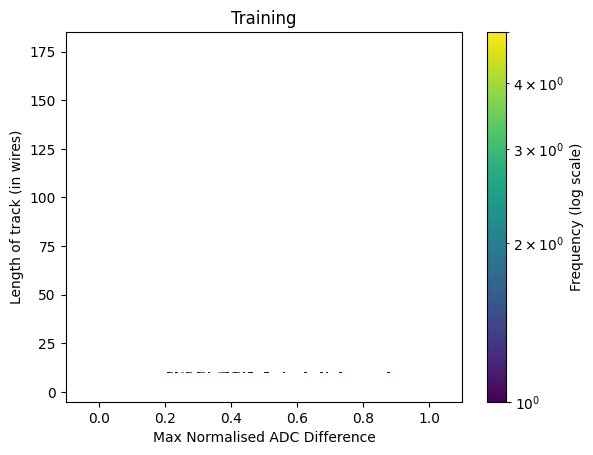

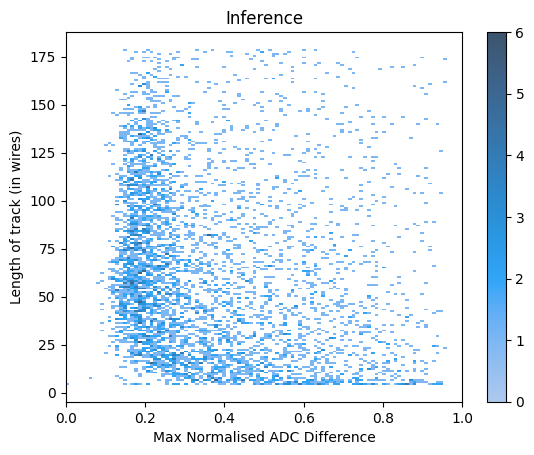

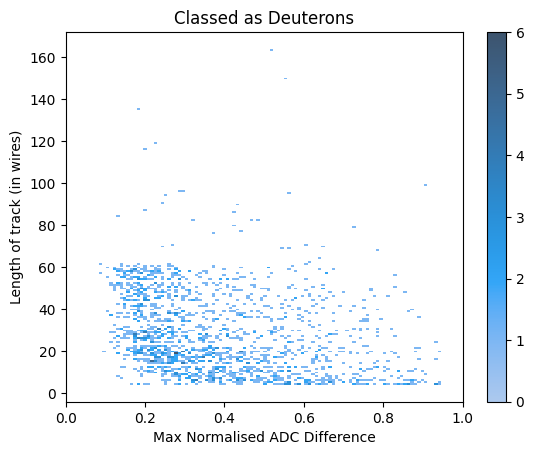

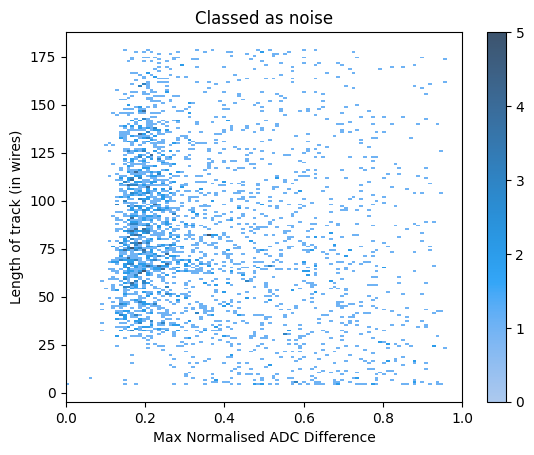

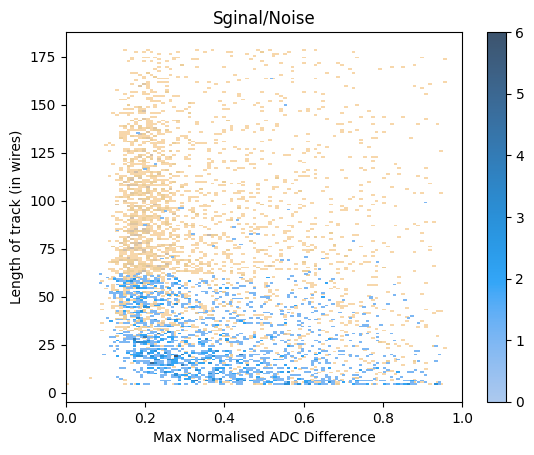

In [212]:
from matplotlib.colors import LogNorm

plt.figure()
h = plt.hist2d(train['maxdiff'], train['lengths'], bins=[100, 176], norm=LogNorm(), cmap='viridis')
plt.xlabel('Max Normalised ADC Difference')
plt.ylabel('Length of track (in wires)')
plt.ylim(-5, 185)
plt.xlim(-0.1,1.1)
plt.title('Training')
plt.colorbar(label='Frequency (log scale)')
plt.show()

plt.figure()
sns.histplot(data=scores, x='maxdiff', y='height',  bins=[100, 176], cbar=True)
plt.xlabel('Max Normalised ADC Difference')
plt.ylabel('Length of track (in wires)')
plt.xlim(0, 1)
plt.title('Inference')
plt.show()

plt.figure()
sns.histplot(data=true, x='maxdiff', y='height', bins=[100, 176], cbar=True)
plt.xlabel('Max Normalised ADC Difference')
plt.ylabel('Length of track (in wires)')
plt.xlim(0, 1)
plt.title('Classed as Deuterons')
plt.show()

plt.figure()
sns.histplot(data=false, x='maxdiff', y='height', bins=[100, 176], cbar=True)
plt.xlabel('Max Normalised ADC Difference')
plt.ylabel('Length of track (in wires)')
plt.xlim(0, 1)
plt.title('Classed as noise')
plt.show()

plt.figure()
sns.histplot(data=false, x='maxdiff', y='height', bins=[100, 176], alpha=0.4, color='orange', label='Noise')
sns.histplot(data=true, x='maxdiff', y='height', bins=[100, 176], cbar=True, label='Signal')
plt.xlabel('Max Normalised ADC Difference')
plt.ylabel('Length of track (in wires)')
plt.xlim(0, 1)
plt.title('Sginal/Noise')
plt.show()

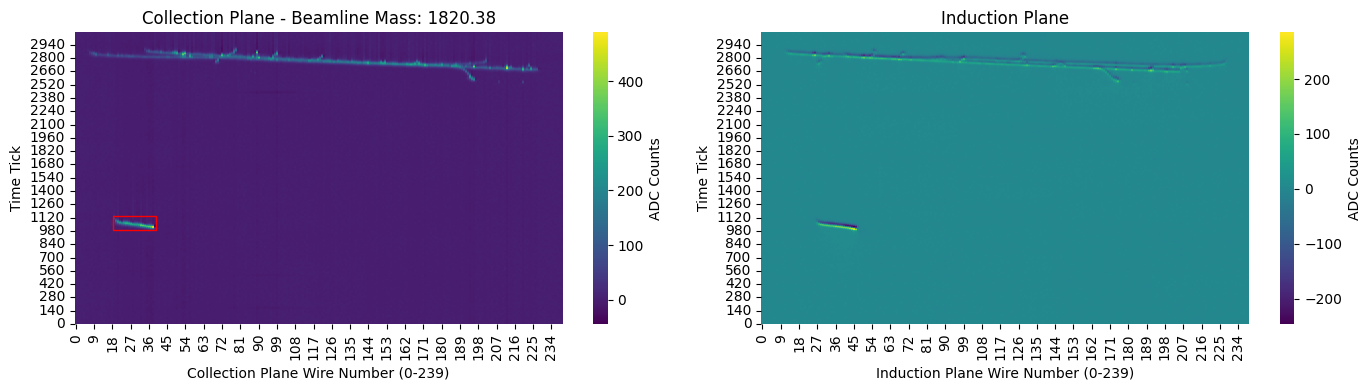

In [249]:
g = true.sample(n=1)

i = 0

row = g.iloc[i]
event = Event(g.iloc[i]['file_path'], index=g.iloc[i]['event_index'], plot=False)

c = event.collection
a = event.induction

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

sns.heatmap(c.T, cmap="viridis", cbar_kws={'label': 'ADC Counts'}, ax=ax1)
ax1.set_xlabel("Collection Plane Wire Number (0-239)")
ax1.set_ylabel("Time Tick")
ax1.set_title(f"Collection Plane - Beamline Mass: {row['beamline_mass']:.2f}")
ax1.invert_yaxis()

start_wire = row['bbox_min_row'] 
start_time = row['bbox_min_col']
width = row['height']
height = row['width']

rect = Rectangle((start_wire, start_time), 
                    width, height, 
                    linewidth=1, 
                    edgecolor='red', 
                    facecolor='none')
ax1.add_patch(rect)

sns.heatmap(a.T, cmap='viridis', cbar_kws={'label': 'ADC Counts'}, ax=ax2)
ax2.set_xlabel("Induction Plane Wire Number (0-239)")
ax2.set_ylabel("Time Tick")
ax2.set_title("Induction Plane")
ax2.invert_yaxis()

# row = g.iloc[i+1]

# start_wire = row['bbox_min_row'] 
# start_time = row['bbox_min_col']
# width = row['height']
# height = row['width']

# rect = Rectangle((start_wire, start_time), 
#                     width, height, 
#                     linewidth=1, 
#                     edgecolor='red', 
#                     facecolor='none')
# ax2.add_patch(rect)



plt.tight_layout()

In [243]:
data = scores['svdd_distance']

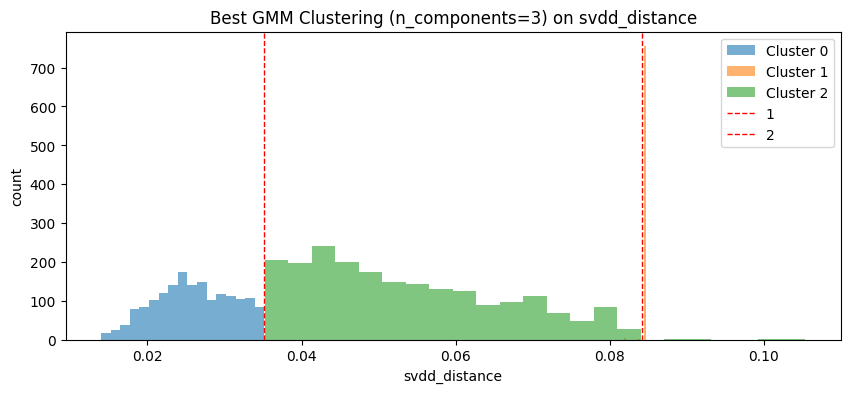

In [255]:
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

data = scores['svdd_distance'].values.reshape(-1, 1)

# Try GMM with 2 and 3 components, pick the best by BIC
lowest_bic = np.inf
best_gmm = None
n_components_range = [2, 3]
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=0)
    gmm.fit(data)
    bic = gmm.bic(data)
    if bic < lowest_bic:
        lowest_bic = bic
        best_gmm = gmm

labels = best_gmm.predict(data)
probs = best_gmm.predict_proba(data).max(axis=1)

plt.figure(figsize=(10,4))
for k in range(best_gmm.n_components):
    plt.hist(data[labels==k], bins='auto', alpha=0.6, label=f'Cluster {k}')

plt.axvline(0.0351, ls="--", lw=1, color='r', label='1')
plt.axvline(0.0842, ls="--", lw=1, color='r', label='2')
plt.xlabel('svdd_distance')
plt.ylabel('count')
plt.title(f'Best GMM Clustering (n_components={best_gmm.n_components}) on svdd_distance')
plt.legend()
plt.show()

/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_p

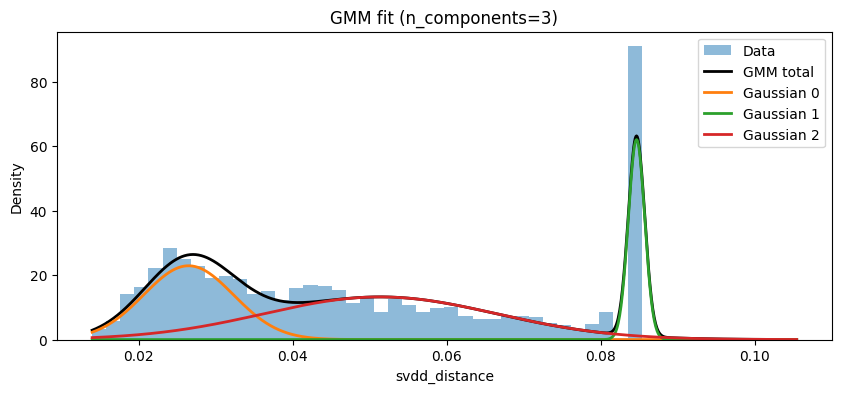

In [194]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

data = scores['svdd_distance'].values.reshape(-1, 1)

# Fit GMM with 2 or 3 components, pick best by BIC
lowest_bic = np.inf
best_gmm = None
n_components_range = [2, 3]
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=0)
    gmm.fit(data)
    bic = gmm.bic(data)
    if bic < lowest_bic:
        lowest_bic = bic
        best_gmm = gmm

labels = best_gmm.predict(data)

# Plot histogram and the fitted Gaussians
plt.figure(figsize=(10, 4))
counts, bins, _ = plt.hist(data, bins=50, density=True, alpha=0.5, label='Data')

x = np.linspace(data.min(), data.max(), 1000).reshape(-1, 1)
logprob = best_gmm.score_samples(x)
pdf = np.exp(logprob)
plt.plot(x, pdf, color='k', lw=2, label='GMM total')

for i in range(best_gmm.n_components):
    mean = best_gmm.means_[i, 0]
    std = np.sqrt(best_gmm.covariances_[i, 0, 0])
    weight = best_gmm.weights_[i]
    gauss = weight * (1/(std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean)/std)**2)
    plt.plot(x, gauss, lw=2, label=f'Gaussian {i}')

plt.xlabel('svdd_distance')
plt.ylabel('Density')
plt.title(f'GMM fit (n_components={best_gmm.n_components})')
plt.legend()
plt.show()

In [290]:
scores['svdd_distance'].value_counts()

svdd_distance
0.084670    755
0.081571      6
0.081100      4
0.080119      4
0.061588      2
           ... 
0.026501      1
0.019161      1
0.045973      1
0.077607      1
0.018705      1
Name: count, Length: 3774, dtype: int64

In [305]:
scores['svdd_distance'][0]

np.float64(0.084669575)

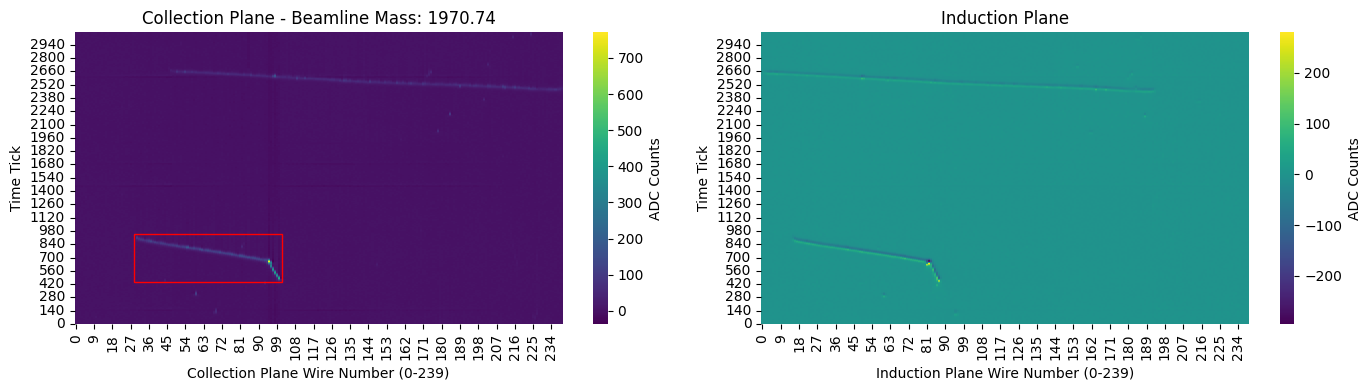

In [329]:
g = scores[scores['svdd_distance'] == 0.084669575].sample(n=1)

i = 0

row = g.iloc[i]
event = Event(g.iloc[i]['file_path'], index=g.iloc[i]['event_index'], plot=False)

c = event.collection
a = event.induction

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

sns.heatmap(c.T, cmap="viridis", cbar_kws={'label': 'ADC Counts'}, ax=ax1)
ax1.set_xlabel("Collection Plane Wire Number (0-239)")
ax1.set_ylabel("Time Tick")
ax1.set_title(f"Collection Plane - Beamline Mass: {row['beamline_mass']:.2f}")
ax1.invert_yaxis()

start_wire = row['bbox_min_row'] 
start_time = row['bbox_min_col']
width = row['height']
height = row['width']

rect = Rectangle((start_wire, start_time), 
                    width, height, 
                    linewidth=1, 
                    edgecolor='red', 
                    facecolor='none')
ax1.add_patch(rect)

sns.heatmap(a.T, cmap='viridis', cbar_kws={'label': 'ADC Counts'}, ax=ax2)
ax2.set_xlabel("Induction Plane Wire Number (0-239)")
ax2.set_ylabel("Time Tick")
ax2.set_title("Induction Plane")
ax2.invert_yaxis()

# row = g.iloc[i+1]

# start_wire = row['bbox_min_row'] 
# start_time = row['bbox_min_col']
# width = row['height']
# height = row['width']

# rect = Rectangle((start_wire, start_time), 
#                     width, height, 
#                     linewidth=1, 
#                     edgecolor='red', 
#                     facecolor='none')
# ax2.add_patch(rect)



plt.tight_layout()

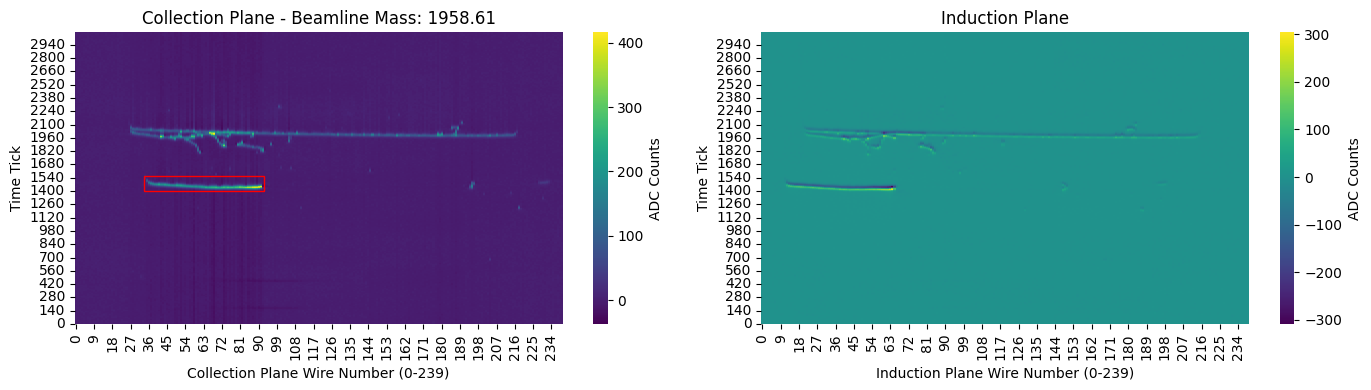

In [360]:
g = scores[(scores['svdd_distance'] > 0.0351 ) & (scores['svdd_distance'] < 0.084669575)].sample(n=1)

i = 0

row = g.iloc[i]
event = Event(g.iloc[i]['file_path'], index=g.iloc[i]['event_index'], plot=False)

c = event.collection
a = event.induction

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

sns.heatmap(c.T, cmap="viridis", cbar_kws={'label': 'ADC Counts'}, ax=ax1)
ax1.set_xlabel("Collection Plane Wire Number (0-239)")
ax1.set_ylabel("Time Tick")
ax1.set_title(f"Collection Plane - Beamline Mass: {row['beamline_mass']:.2f}")
ax1.invert_yaxis()

start_wire = row['bbox_min_row'] 
start_time = row['bbox_min_col']
width = row['height']
height = row['width']

rect = Rectangle((start_wire, start_time), 
                    width, height, 
                    linewidth=1, 
                    edgecolor='red', 
                    facecolor='none')
ax1.add_patch(rect)

sns.heatmap(a.T, cmap='viridis', cbar_kws={'label': 'ADC Counts'}, ax=ax2)
ax2.set_xlabel("Induction Plane Wire Number (0-239)")
ax2.set_ylabel("Time Tick")
ax2.set_title("Induction Plane")
ax2.invert_yaxis()

# row = g.iloc[i+1]

# start_wire = row['bbox_min_row'] 
# start_time = row['bbox_min_col']
# width = row['height']
# height = row['width']

# rect = Rectangle((start_wire, start_time), 
#                     width, height, 
#                     linewidth=1, 
#                     edgecolor='red', 
#                     facecolor='none')
# ax2.add_patch(rect)



plt.tight_layout()

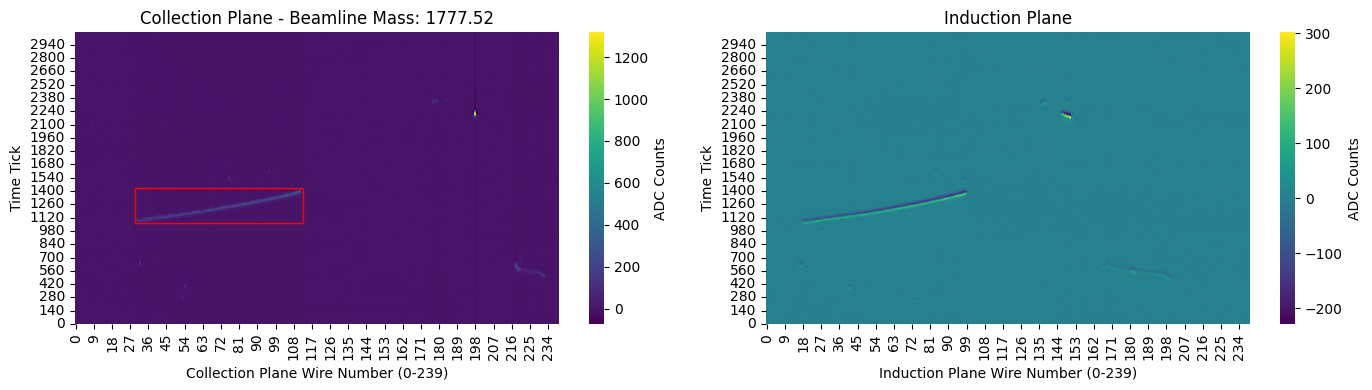

In [371]:
g = scores[(scores['svdd_distance'] < 0.0351 )].sample(n=1)

i = 0

row = g.iloc[i]
event = Event(g.iloc[i]['file_path'], index=g.iloc[i]['event_index'], plot=False)

c = event.collection
a = event.induction

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

sns.heatmap(c.T, cmap="viridis", cbar_kws={'label': 'ADC Counts'}, ax=ax1)
ax1.set_xlabel("Collection Plane Wire Number (0-239)")
ax1.set_ylabel("Time Tick")
ax1.set_title(f"Collection Plane - Beamline Mass: {row['beamline_mass']:.2f}")
ax1.invert_yaxis()

start_wire = row['bbox_min_row'] 
start_time = row['bbox_min_col']
width = row['height']
height = row['width']

rect = Rectangle((start_wire, start_time), 
                    width, height, 
                    linewidth=1, 
                    edgecolor='red', 
                    facecolor='none')
ax1.add_patch(rect)

sns.heatmap(a.T, cmap='viridis', cbar_kws={'label': 'ADC Counts'}, ax=ax2)
ax2.set_xlabel("Induction Plane Wire Number (0-239)")
ax2.set_ylabel("Time Tick")
ax2.set_title("Induction Plane")
ax2.invert_yaxis()

# row = g.iloc[i+1]

# start_wire = row['bbox_min_row'] 
# start_time = row['bbox_min_col']
# width = row['height']
# height = row['width']

# rect = Rectangle((start_wire, start_time), 
#                     width, height, 
#                     linewidth=1, 
#                     edgecolor='red', 
#                     facecolor='none')
# ax2.add_patch(rect)



plt.tight_layout()

In [ ]:
deuterons = scores[(scores['svdd_distance'] < 0.0351)]

,event_idx,run,subrun,event,file_path,event_index,particle_type,plane,cluster_idx,area,...,matrix_transformed,column_maxes,normalised,adcdiff,maxdiff,svdd_distance,is_deuteron_pred,p,m,beamline_mass
4,10,9541,52,3741,/Users/user/data/research/proton-deuteron/rawd...,0,deuteron,collection,4,2442.0,...,"[[18.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0...","[148.0, 225.0, 229.0, 227.0, 186.0, 240.0, 231...","[0.22458270106221548, 0.34142640364188165, 0.3...","[0.11684370257966617, 0.006069802731411222, -0...",0.218513,0.025529,True,0,0,2038.09
11,27,9452,348,32257,/Users/user/data/research/proton-deuteron/rawd...,0,deuteron,collection,5,1655.0,...,"[[18.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0....","[77.0, 159.0, 213.0, 233.0, 200.0, 201.0, 213....","[0.17303370786516853, 0.35730337078651686, 0.4...","[0.18426966292134833, 0.12134831460674156, 0.0...",0.184270,0.022735,True,0,0,1710.57
19,38,9452,124,11560,/Users/user/data/research/proton-deuteron/rawd...,0,deuteron,collection,3,1343.0,...,"[[16.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0,...","[23.0, 145.0, 218.0, 183.0, 182.0, 271.0, 235....","[0.04883227176220807, 0.3078556263269639, 0.46...","[0.25902335456475584, 0.15498938428874737, -0....",0.259023,0.022655,True,0,0,1904.09
24,49,9474,257,21992,/Users/user/data/research/proton-deuteron/rawd...,0,deuteron,collection,2,1737.0,...,"[[16.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0....","[28.0, 150.0, 205.0, 191.0, 203.0, 199.0, 214....","[0.060215053763440864, 0.3225806451612903, 0.4...","[0.26236559139784943, 0.11827956989247312, -0....",0.262366,0.030511,True,0,0,1711.36
27,55,9491,313,20401,/Users/user/data/research/proton-deuteron/rawd...,0,deuteron,collection,1,2579.0,...,"[[0.0, 16.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0...","[17.0, 247.0, 160.0, 150.0, 157.0, 155.0, 211....","[0.04176904176904177, 0.6068796068796068, 0.39...","[0.5651105651105651, -0.21375921375921375, -0....",0.565111,0.025113,True,0,1,1982.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4535,6944,8634,304,18821,/Users/user/data/research/proton-deuteron/rawd...,0,deuteron,collection,0,1122.0,...,"[[0.0, 16.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0...","[89.0, 276.0, 240.0, 266.0, 303.0, 305.0, 251....","[0.20649651972157773, 0.6403712296983759, 0.55...","[0.43387470997679817, -0.08352668213457082, 0....",0.433875,0.027348,True,0,0,1644.59
4537,6946,9493,115,8574,/Users/user/data/research/proton-deuteron/rawd...,0,deuteron,collection,3,808.0,...,"[[16.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, ...","[98.0, 214.0, 307.0, 345.0, 383.0, 360.0, 391....","[0.17753623188405798, 0.38768115942028986, 0.5...","[0.21014492753623187, 0.16847826086956524, 0.0...",0.210145,0.018014,True,0,0,1891.80
4538,6947,9536,112,7413,/Users/user/data/research/proton-deuteron/rawd...,0,deuteron,collection,0,1155.0,...,"[[16.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0....","[56.0, 280.0, 283.0, 258.0, 255.0, 217.0, 246....","[0.13526570048309178, 0.6763285024154589, 0.68...","[0.5410628019323671, 0.007246376811594235, -0....",0.541063,0.027426,True,0,0,1947.46
4540,6950,8667,276,21860,/Users/user/data/research/proton-deuteron/rawd...,0,deuteron,collection,2,3305.0,...,"[[0.0, 17.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0,...","[16.0, 208.0, 226.0, 163.0, 160.0, 171.0, 186....","[0.032520325203252036, 0.42276422764227645, 0....","[0.3902439024390244, 0.036585365853658514, -0....",0.390244,0.019534,True,0,0,1695.63


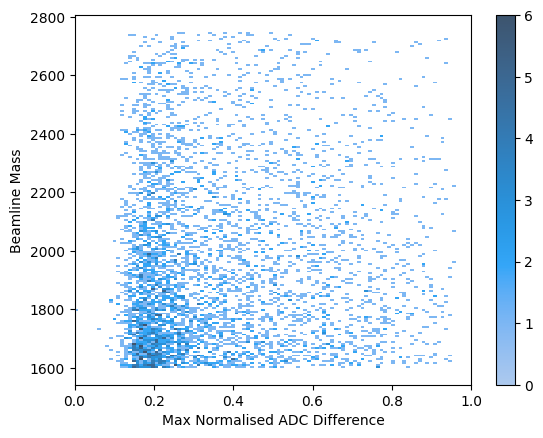

In [596]:
plt.figure()
sns.histplot(data=scores, x='maxdiff', y='beamline_mass', bins=[100, 176], cbar=True)
plt.xlabel('Max Normalised ADC Difference')
plt.ylabel('Beamline Mass')
plt.xlim(0, 1)
plt.show()

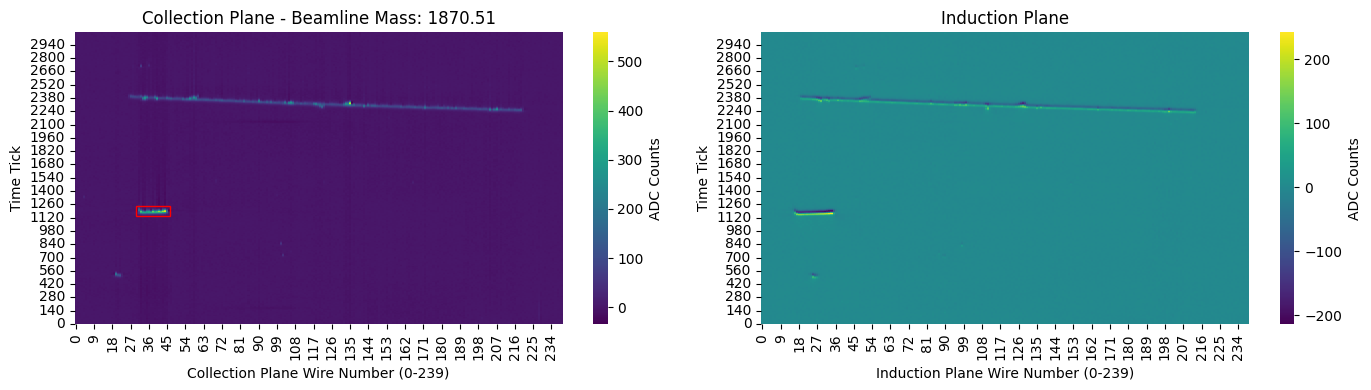

In [587]:
g = deuterons[(deuterons['maxdiff'] > 0.3) & (deuterons['maxdiff'] < 0.4)].sample(n=1)

i = 0

row = g.iloc[i]
event = Event(g.iloc[i]['file_path'], index=g.iloc[i]['event_index'], plot=False)

c = event.collection
a = event.induction

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

sns.heatmap(c.T, cmap="viridis", cbar_kws={'label': 'ADC Counts'}, ax=ax1)
ax1.set_xlabel("Collection Plane Wire Number (0-239)")
ax1.set_ylabel("Time Tick")
ax1.set_title(f"Collection Plane - Beamline Mass: {row['beamline_mass']:.2f}")
ax1.invert_yaxis()

start_wire = row['bbox_min_row'] 
start_time = row['bbox_min_col']
width = row['height']
height = row['width']

rect = Rectangle((start_wire, start_time), 
                    width, height, 
                    linewidth=1, 
                    edgecolor='red', 
                    facecolor='none')
ax1.add_patch(rect)

sns.heatmap(a.T, cmap='viridis', cbar_kws={'label': 'ADC Counts'}, ax=ax2)
ax2.set_xlabel("Induction Plane Wire Number (0-239)")
ax2.set_ylabel("Time Tick")
ax2.set_title("Induction Plane")
ax2.invert_yaxis()

# row = g.iloc[i+1]

# start_wire = row['bbox_min_row'] 
# start_time = row['bbox_min_col']
# width = row['height']
# height = row['width']

# rect = Rectangle((start_wire, start_time), 
#                     width, height, 
#                     linewidth=1, 
#                     edgecolor='red', 
#                     facecolor='none')
# ax2.add_patch(rect)



plt.tight_layout()

In [665]:
deuterons = deuterons[deuterons['maxdiff'] > 0.3]

In [666]:
a = deuterons['image_intensity'].sample(n=1).iloc[0]; print(a)
b = a.sum(axis=1); print(b)
c = a.max(axis=1); print(c) 

[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ... -0. -0. -0.]
 [ 0.  0.  0. ... -0. -0. -0.]
 ...
 [-0. -0. -0. ... 18. 17. 16.]
 [-0. -0. -0. ...  0.  0.  0.]
 [-0. -0. -0. ... -0. -0. -0.]]
[ 2521.  6731.  7964.  7964.  8197.  9121.  9862.  9168.  9710.  9895.
 10165. 11253.  9543.  9096.  9767. 12164. 12102. 11807. 13296. 14850.
  1023.]
[ 62. 208. 272. 272. 252. 278. 291. 269. 286. 292. 288. 310. 288. 288.
 329. 396. 390. 366. 379. 439.  53.]


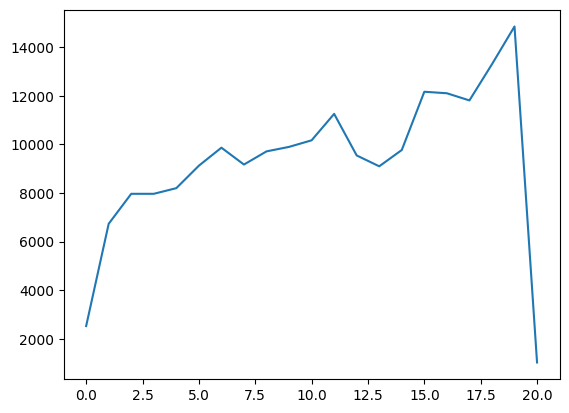

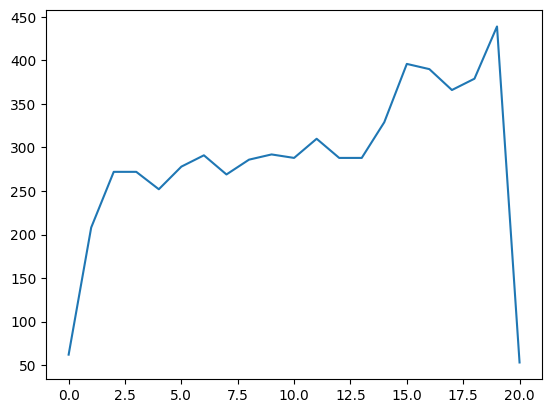

In [667]:
plt.plot(b); plt.show()
plt.plot(c)

In [656]:
g['maxdiff']

1353    0.370304
Name: maxdiff, dtype: float64

In [592]:
b = deuterons[(deuterons['maxdiff'] > 0.3) & (deuterons['maxdiff'] < 0.4)]